**Predictive Analytics HW3**

In [2]:
from google.colab import files
uploaded = files.upload()


Saving spambase.data to spambase.data


**Question 2 : Part 1**

                 Model  Accuracy  Precision    Recall  F1-Score       AUC  \
0  Logistic Regression  0.925019   0.920916  0.886355  0.903028  0.970688   
1                  KNN  0.908717   0.893762  0.872026  0.882714  0.950532   
2                  SVM  0.932191   0.932261  0.892984  0.912091  0.973927   
3        Decision Tree  0.908717   0.878710  0.891882  0.885083  0.905731   
4        Random Forest  0.951532   0.951359  0.924422  0.937613  0.984536   
5    Gradient Boosting  0.943926   0.942713  0.913394  0.927694  0.984921   
6       Neural Network  0.943709   0.929451  0.927731  0.928498  0.980641   

      Kappa  Misclassification Rate  Misclassification Cost  
0  0.841952                0.074981                    69.0  
1  0.808016                0.091283                    84.0  
2  0.856945                0.067809                    62.4  
3  0.809385                0.091283                    84.0  
4  0.898000                0.048468                    44.6  
5  0.881923

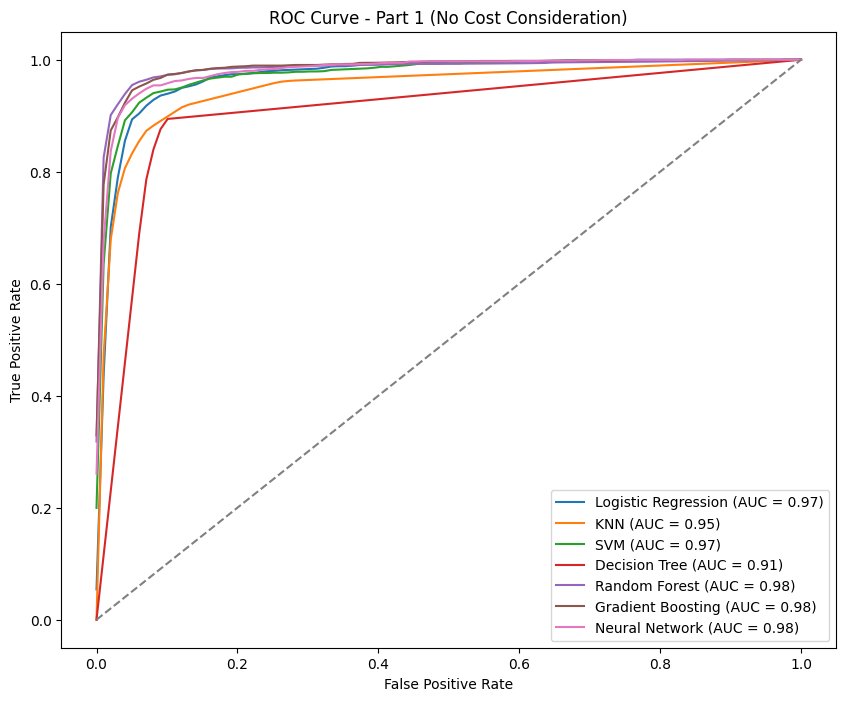

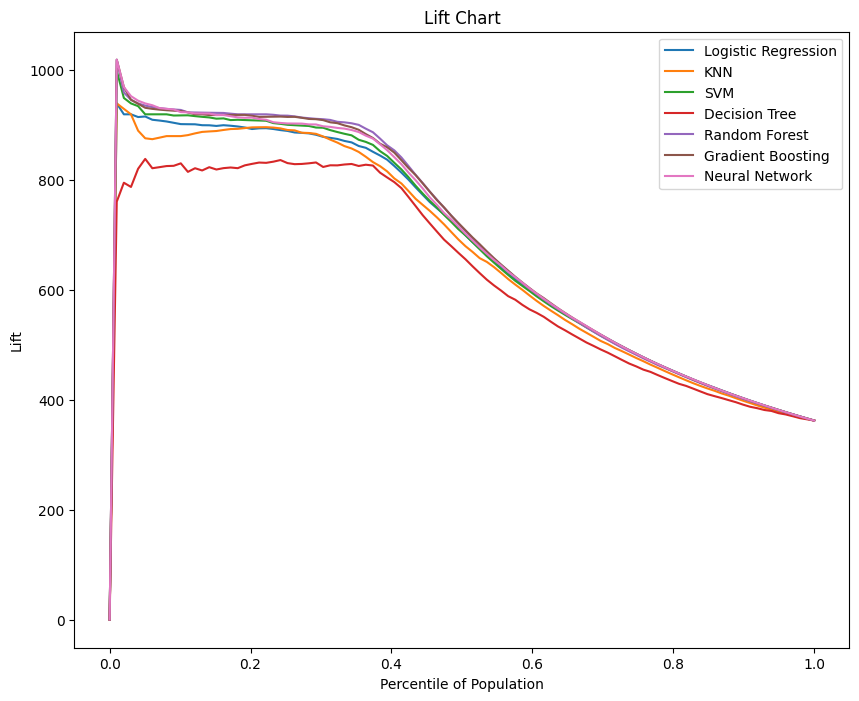

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, cohen_kappa_score, roc_curve, auc, confusion_matrix
)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

# Load dataset
data = pd.read_csv('spambase.data', header=None)
X = data.iloc[:, :-1].values  # Features
y = data.iloc[:, -1].values  # Labels

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Models to evaluate
models = [
    ('Logistic Regression', LogisticRegression(max_iter=10000)),
    ('KNN', KNeighborsClassifier()),
    ('SVM', SVC(probability=True)),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier()),
    ('Neural Network', MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000))
]

# Nested Cross-validation
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store results
results_part1 = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1-Score": [],
    "AUC": [],
    "Kappa": [],
    "Misclassification Rate": [],
    "Misclassification Cost": []
}

# Store ROC and Lift Chart data
fpr_all = {}  # Dictionary to store false positive rates
tpr_all = {}  # Dictionary to store true positive rates
auc_scores = {}  # Dictionary to store AUC values
lift_data = {}  # Store lift chart values

# Evaluate models
for model_name, model in models:
    accuracy, precision, recall, f1, kappa, misclassification_rate, misclassification_cost = [], [], [], [], [], [], []
    model_fprs, model_tprs, model_aucs = [], [], []  # Store ROC data for each fold
    lift_values = []  # Store Lift Chart data

    for train_idx, test_idx in outer_cv.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        # Compute metrics
        accuracy.append(accuracy_score(y_test, y_pred))
        precision.append(precision_score(y_test, y_pred))
        recall.append(recall_score(y_test, y_pred))
        f1.append(f1_score(y_test, y_pred))
        kappa.append(cohen_kappa_score(y_test, y_pred))
        model_auc = roc_auc_score(y_test, y_pred_proba)
        model_aucs.append(model_auc)

        # Misclassification rate: (FP + FN) / Total
        misclassification_rate.append(1 - accuracy_score(y_test, y_pred))

        # Misclassification cost (equal cost for FP and FN)
        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()
        cost = fp + fn  # Equal cost for FP and FN
        misclassification_cost.append(cost)

        # ROC Curve data
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        model_fprs.append(fpr)
        model_tprs.append(tpr)

        # Lift Chart data
        df = pd.DataFrame({'y_true': y_test, 'y_score': y_pred_proba})
        df = df.sort_values(by='y_score', ascending=False)
        df['cumulative_positives'] = df['y_true'].cumsum()
        df['percentile'] = np.linspace(0, 1, len(df))
        lift_curve = df['cumulative_positives'] / df['percentile'].replace(0, 1)  # Avoid division by zero

        # Interpolate to ensure consistency across folds
        percentile_points = np.linspace(0, 1, 100)
        interpolated_lift = np.interp(percentile_points, df['percentile'], lift_curve)
        lift_values.append(interpolated_lift)

    # Store aggregated results
    results_part1["Model"].append(model_name)
    results_part1["Accuracy"].append(np.mean(accuracy))
    results_part1["Precision"].append(np.mean(precision))
    results_part1["Recall"].append(np.mean(recall))
    results_part1["F1-Score"].append(np.mean(f1))
    results_part1["AUC"].append(np.mean(model_aucs))
    results_part1["Kappa"].append(np.mean(kappa))
    results_part1["Misclassification Rate"].append(np.mean(misclassification_rate))
    results_part1["Misclassification Cost"].append(np.mean(misclassification_cost))  # Average misclassification cost

    # Store ROC data for plotting
    fpr_all[model_name] = model_fprs
    tpr_all[model_name] = model_tprs
    auc_scores[model_name] = np.mean(model_aucs)  # Average AUC per model
    lift_data[model_name] = np.mean(lift_values, axis=0)  # Average lift values across folds

# Convert results to DataFrame
df_results_part1 = pd.DataFrame(results_part1)
print(df_results_part1)

# Plot ROC Curves
plt.figure(figsize=(10, 8))
for model_name in df_results_part1["Model"]:
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.mean([np.interp(mean_fpr, fpr, tpr) for fpr, tpr in zip(fpr_all[model_name], tpr_all[model_name])], axis=0)
    mean_auc = auc_scores[model_name]

    plt.plot(mean_fpr, mean_tpr, label=f'{model_name} (AUC = {mean_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle="--", color='gray')  # Baseline diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Part 1 (No Cost Consideration)')
plt.legend(loc='lower right')
plt.show()

# Plot Lift Chart
plt.figure(figsize=(10, 8))
percentiles = np.linspace(0, 1, 100)
for model_name in df_results_part1["Model"]:
    plt.plot(percentiles, lift_data[model_name], label=model_name)

plt.xlabel('Percentile of Population')
plt.ylabel('Lift')
plt.title('Lift Chart')
plt.legend(loc='upper right')
plt.show()


**Part 2**

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
                    Model  Accuracy  Precision    Recall  F1-Score       AUC  \
0     Logistic Regression  0.741793   0.604884  0.994486  0.752214  0.968590   
1                     KNN  0.902415   0.856754  0.903472  0.879457  0.958723   
2                     SVM  0.779392   0.645081  0.980150  0.777997  0.956621   
3           Decision Tree  0.912412   0.894730  0.881413  0.887976  0.944252   
4           Random Forest  0.946751   0.946133  0.917256  0.931379  0.952452   
5       Gradient Boosting  0.920233   0.846819  0.974071  0.905921  0.957728   
6  Neural Network (Keras)  0.899373   0.811150  0.972412  0.884172  0.960882   

      Kappa  Misclassification Cost  
0  0.514071                   255.6  
1  0.797581                   404.8  
2  0.576673                   267.8  
3  0.816082                   467.6  
4  0.887895                   319.0  
5  0.837284                   158.0  
6  0.796580   

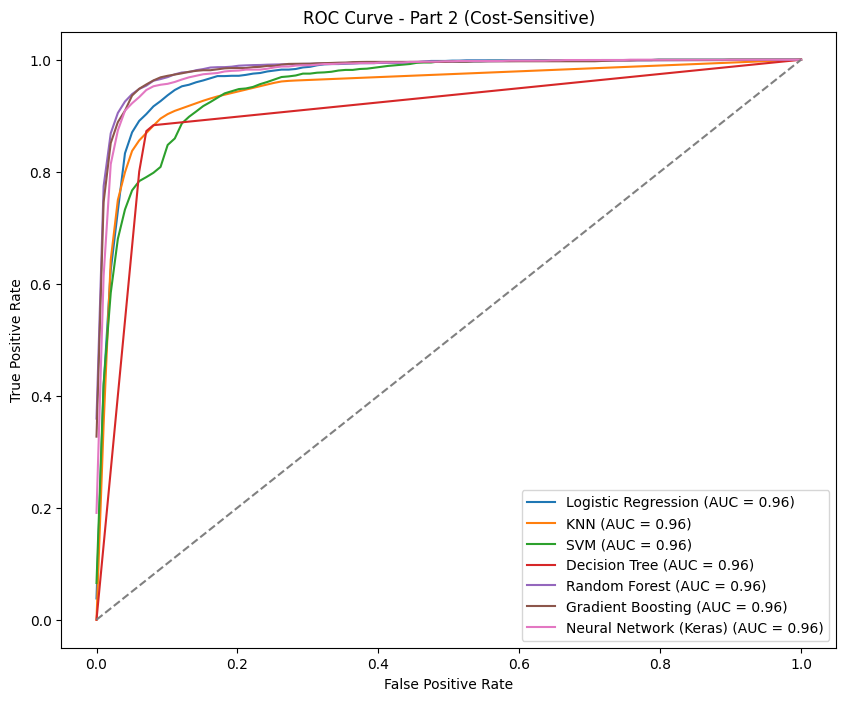

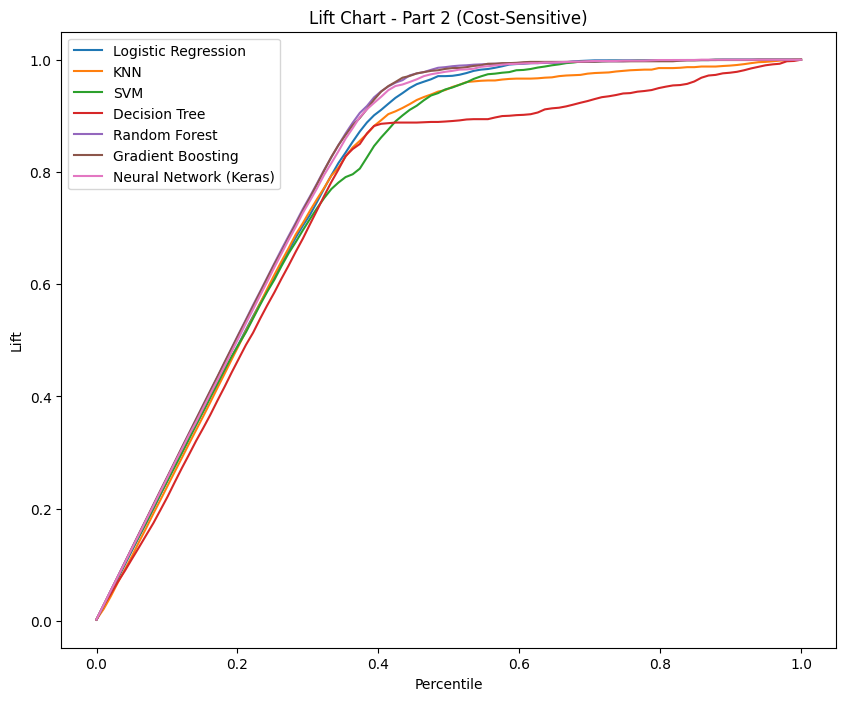

In [28]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, cohen_kappa_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import RandomOverSampler  # For random oversampling
import keras
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('spambase.data', header=None)
X = data.iloc[:, :-1].values  # Features
y = data.iloc[:, -1].values  # Labels

# Scale the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Misclassification Costs
C_FN = 10  # Cost for False Negative (Class 1 predicted as Class 0)
C_FP = 1   # Cost for False Positive (Class 0 predicted as Class 1)

# List of models to evaluate with cost-sensitive classification
models = [
    ('Logistic Regression', LogisticRegression(max_iter=10000, class_weight={0: 1, 1: 10})),  # Apply class weights
    ('KNN', KNeighborsClassifier()),  # KNN does not support sample_weight
    ('SVM', SVC(probability=True, class_weight={0: 1, 1: 10})),  # Apply class weights
    ('Decision Tree', DecisionTreeClassifier(class_weight={0: 1, 1: 10})),  # Apply class weights
    ('Random Forest', RandomForestClassifier(class_weight={0: 1, 1: 10})),  # Apply class weights
    ('Gradient Boosting', GradientBoostingClassifier()),  # Gradient Boosting typically does not have class_weight param
    ('Neural Network (Keras)', None)  # We'll handle this separately with Keras
]

# Nested Cross-validation
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results_part2 = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1-Score": [],
    "AUC": [],
    "Kappa": [],
    "Misclassification Cost": [],  # To store misclassification cost results
}

# For ROC curve plotting
fpr_all = []
tpr_all = []
auc_scores = []

# For Lift chart plotting
lift_data = {}

# Evaluate each model using Nested Cross-Validation
for model_name, model in models:
    accuracy, precision, recall, f1, kappa, misclassification_cost = [], [], [], [], [], []
    model_fprs, model_tprs, model_lift = [], [], []
    for train_idx, test_idx in outer_cv.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Handle sample weights for cost-sensitive classification
        if model_name == "KNN" or model_name == "Neural Network (Keras)":
            sample_weight = None  # KNN and MLPClassifier do not support sample_weight
        else:
            # Calculate sample weights (10x for class 1, 1x for class 0)
            class_0_weight = sum(y_train == 0) / len(y_train)
            class_1_weight = sum(y_train == 1) / len(y_train)
            sample_weight = np.where(y_train == 0, class_0_weight, class_1_weight * 10)

        # Train and evaluate the model
        if model_name == "Neural Network (Keras)":
            # Build the Keras model
            keras_model = Sequential()
            keras_model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
            keras_model.add(Dense(32, activation='relu'))
            keras_model.add(Dense(1, activation='sigmoid'))

            keras_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

            # Fit the Keras model with class weights for cost-sensitive classification
            class_weight = {0: 1, 1: 10}  # 10x weight for class 1 (spam)
            keras_model.fit(X_train, y_train, epochs=10, batch_size=32, class_weight=class_weight, verbose=0)

            # Predict using the model
            y_pred = (keras_model.predict(X_test) > 0.5).astype("int32")
            y_pred_proba = keras_model.predict(X_test).flatten()

        elif model_name == "KNN":
            # For KNN, we use Random Oversampling to balance the classes
            ros = RandomOverSampler(sampling_strategy='auto', random_state=42)  # Random oversampling
            X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
            model.fit(X_train_resampled, y_train_resampled)  # Fit the model with resampled data
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1]

        else:
            model.fit(X_train, y_train, sample_weight=sample_weight)  # Fit model with sample_weight
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1]

        # Calculate metrics
        accuracy.append(accuracy_score(y_test, y_pred))
        precision.append(precision_score(y_test, y_pred))
        recall.append(recall_score(y_test, y_pred))
        f1.append(f1_score(y_test, y_pred))
        kappa.append(cohen_kappa_score(y_test, y_pred))
        auc_scores.append(roc_auc_score(y_test, y_pred_proba))

        # Misclassification Cost Calculation
        cost = np.sum((y_pred == 0) & (y_test == 1)) * C_FN + np.sum((y_pred == 1) & (y_test == 0)) * C_FP
        misclassification_cost.append(cost)

        # ROC curve
        fpr_fold, tpr_fold, _ = roc_curve(y_test, y_pred_proba)
        model_fprs.append(fpr_fold)
        model_tprs.append(tpr_fold)

        # Lift calculation
        sorted_indices = np.argsort(y_pred_proba)[::-1]
        y_test_sorted = y_test[sorted_indices]
        lift = np.cumsum(y_test_sorted) / np.sum(y_test_sorted)
        model_lift.append(lift)

    # Interpolate ROC curve data to ensure consistent length (e.g., 100 points)
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.zeros_like(mean_fpr)

    for fpr, tpr in zip(model_fprs, model_tprs):
        mean_tpr += np.interp(mean_fpr, fpr, tpr)

    mean_tpr /= len(model_fprs)  # Average TPR values across folds
    fpr_all.append(mean_fpr)
    tpr_all.append(mean_tpr)

    # Ensure lift values have consistent length
    lift_length = 100  # Number of percentiles
    mean_lift = np.zeros(lift_length)
    for lift_values in model_lift:
        interpolated_lift = np.interp(np.linspace(0, 1, lift_length), np.linspace(0, 1, len(lift_values)), lift_values)
        mean_lift += interpolated_lift

    mean_lift /= len(model_lift)  # Average lift values across folds
    lift_data[model_name] = mean_lift

    # Store results
    results_part2["Model"].append(model_name)
    results_part2["Accuracy"].append(np.mean(accuracy))
    results_part2["Precision"].append(np.mean(precision))
    results_part2["Recall"].append(np.mean(recall))
    results_part2["F1-Score"].append(np.mean(f1))
    results_part2["AUC"].append(np.mean(auc_scores))
    results_part2["Kappa"].append(np.mean(kappa))
    results_part2["Misclassification Cost"].append(np.mean(misclassification_cost))

# Display results for Part 2
df_results_part2 = pd.DataFrame(results_part2)
print(df_results_part2)

# Plot ROC curve for all models in Part 2
plt.figure(figsize=(10, 8))
for i, model_name in enumerate(df_results_part2["Model"]):
    plt.plot(fpr_all[i], tpr_all[i], label=f'{model_name} (AUC = {np.mean(auc_scores):.2f})')

plt.plot([0, 1], [0, 1], linestyle="--", color='gray')  # Diagonal line for random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Part 2 (Cost-Sensitive)')
plt.legend(loc='lower right')
plt.show()

# Plot Lift Chart for all models in Part 2
plt.figure(figsize=(10, 8))
for model_name in df_results_part2["Model"]:
    plt.plot(np.linspace(0, 1, 100), lift_data[model_name], label=model_name)

plt.xlabel('Percentile')
plt.ylabel('Lift')
plt.title('Lift Chart - Part 2 (Cost-Sensitive)')
plt.legend(loc='best')
plt.show()


**Comparision of parts 1 and 2**

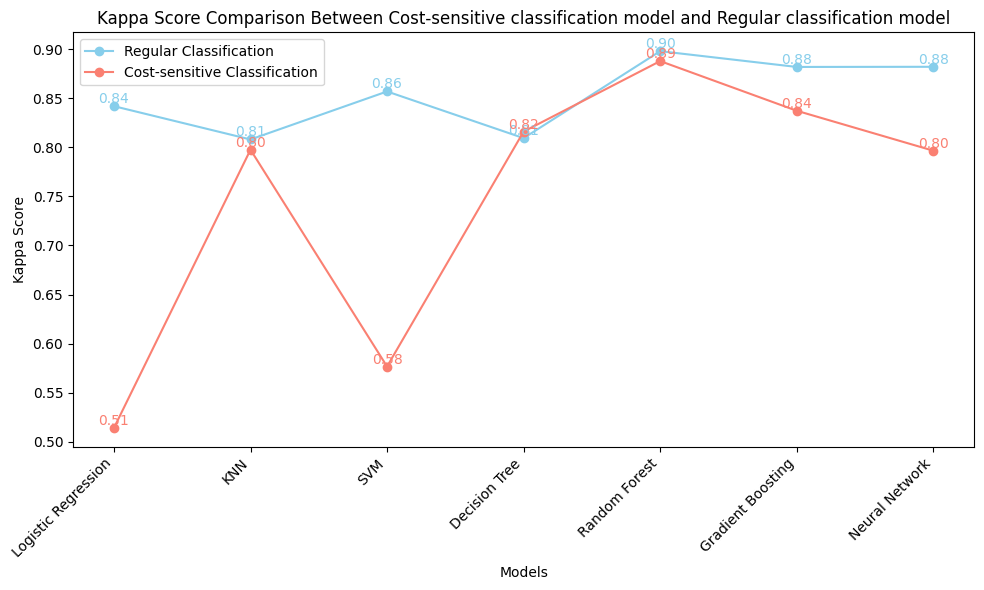

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you already have the kappa scores from both part 1 and part 2 stored in lists/arrays
# Extract the kappa scores from both part 1 and part 2 results

# Part 1 kappa scores
kappa_part1 = df_results_part1["Kappa"].values  # Replace with your actual kappa values from part 1

# Part 2 kappa scores
kappa_part2 = df_results_part2["Kappa"].values  # Replace with your actual kappa values from part 2

# Model names for both parts
models = df_results_part1["Model"].values  # Assuming same models in part 1 and part 2

# Plot comparison using a line graph
plt.figure(figsize=(10, 6))

# Line plots for Part 1 and Part 2 kappa scores
plt.plot(models, kappa_part1, label='Regular Classification', marker='o', linestyle='-', color='skyblue')
plt.plot(models, kappa_part2, label='Cost-sensitive Classification', marker='o', linestyle='-', color='salmon')

# Indicating values on the points for both lines
for i, (kappa1, kappa2) in enumerate(zip(kappa_part1, kappa_part2)):
    plt.text(models[i], kappa1, f'{kappa1:.2f}', ha='center', va='bottom', color='skyblue', fontsize=10)
    plt.text(models[i], kappa2, f'{kappa2:.2f}', ha='center', va='bottom', color='salmon', fontsize=10)

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Kappa Score')
plt.title('Kappa Score Comparison Between Cost-sensitive classification model and Regular classification model')

# Rotate x-ticks for better readability
plt.xticks(rotation=45, ha='right')

# Add legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()
